Активний GPU: /physical_device:GPU:0
Found 20947 images belonging to 10 classes.
Found 5232 images belonging to 10 classes.

Класи: ['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']

Навчання моделі...
Epoch 1/15
655/655 ━━━━━━━━━━━━━━━━━━━━ 177s 259ms/step - accuracy: 0.2859 - loss: 2.8146 - val_accuracy: 0.3133 - val_loss: 2.1236
Epoch 2/15
655/655 ━━━━━━━━━━━━━━━━━━━━ 203s 309ms/step - accuracy: 0.4707 - loss: 1.5650 - val_accuracy: 0.3251 - val_loss: 2.1112
Epoch 3/15
655/655 ━━━━━━━━━━━━━━━━━━━━ 93s 142ms/step - accuracy: 0.5563 - loss: 1.3162 - val_accuracy: 0.4203 - val_loss: 1.6770
Epoch 4/15
655/655 ━━━━━━━━━━━━━━━━━━━━ 74s 113ms/step - accuracy: 0.6084 - loss: 1.1598 - val_accuracy: 0.6026 - val_loss: 1.1693
Epoch 5/15
655/655 ━━━━━━━━━━━━━━━━━━━━ 64s 97ms/step - accuracy: 0.6499 - loss: 1.0319 - val_accuracy: 0.5638 - val_loss: 1.2805
Epoch 6/15
655/655 ━━━━━━━━━━━━━━━━━━━━ 63s 96ms/step - accuracy: 0.6850 - loss: 0.931

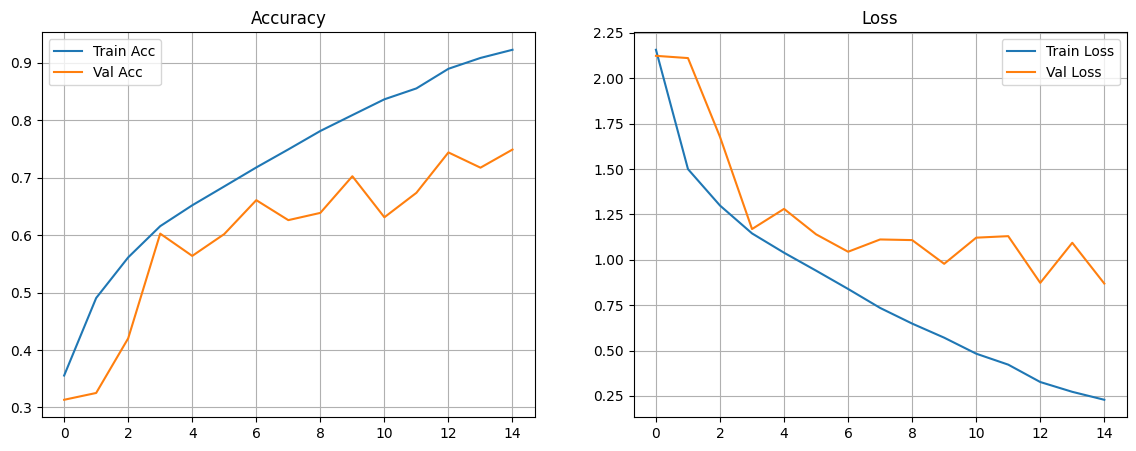

164/164 ━━━━━━━━━━━━━━━━━━━━ 11s 62ms/step


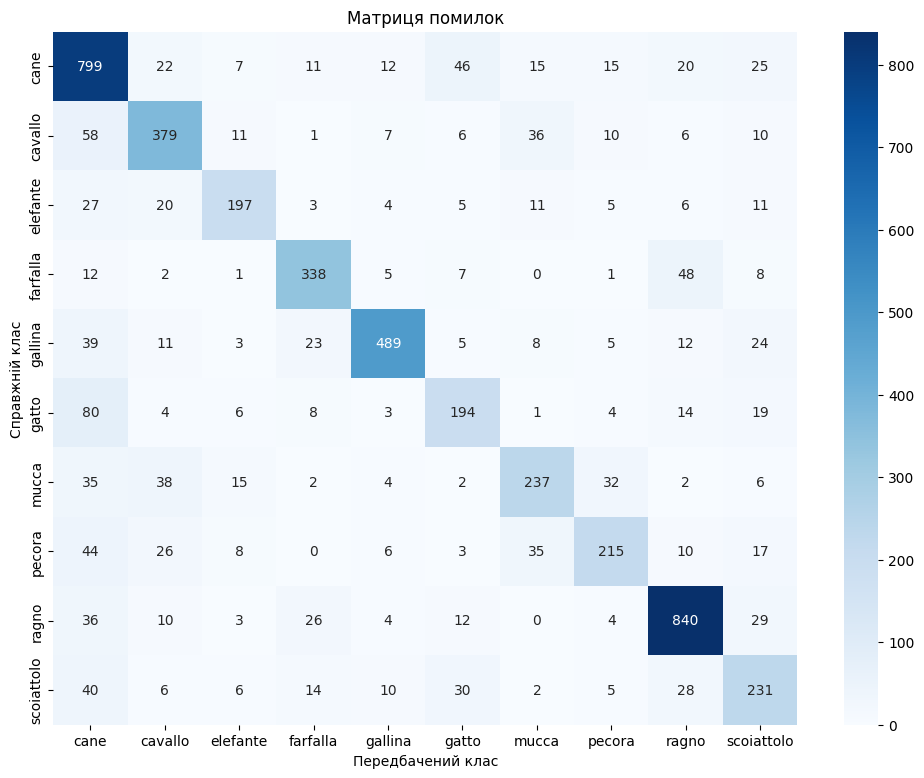

              precision    recall  f1-score   support

        cane       0.68      0.82      0.75       972
     cavallo       0.73      0.72      0.73       524
    elefante       0.77      0.68      0.72       289
    farfalla       0.79      0.80      0.80       422
     gallina       0.90      0.79      0.84       619
       gatto       0.63      0.58      0.60       333
       mucca       0.69      0.64      0.66       373
      pecora       0.73      0.59      0.65       364
       ragno       0.85      0.87      0.86       964
  scoiattolo       0.61      0.62      0.61       372

    accuracy                           0.75      5232
   macro avg       0.74      0.71      0.72      5232
weighted avg       0.75      0.75      0.75      5232



FileUpload(value=(), accept='image/*', description='Upload', multiple=True)

Button(description='Передбачити', style=ButtonStyle())

Output()

In [2]:
import os
import io
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, Flatten, Dense,
    Dropout, BatchNormalization
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
import ipywidgets as widgets
from IPython.display import display

gpu_devices = tf.config.list_physical_devices('GPU')
if gpu_devices:
    try:
        tf.config.set_visible_devices(gpu_devices[0], 'GPU')
        tf.config.experimental.set_memory_growth(gpu_devices[0], True)
        print(f"Активний GPU: {gpu_devices[0].name}")
    except RuntimeError as e:
        print("Помилка GPU:", e)
else:
    print("GPU не знайдено, використовується CPU.")

# --- Завантаження датасету ---
import kagglehub
extract_path = kagglehub.dataset_download("alessiocorrado99/animals10")

data_dir = os.path.join(extract_path, "raw-img")


img_size = (227, 227)
batch_size = 32

datagen = ImageDataGenerator(
    rescale=1.0/255,
    validation_split=0.2
)

train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='sparse',
    subset='training',
    shuffle=True
)

val_generator = datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='sparse',
    subset='validation',
    shuffle=False
)

class_names = list(train_generator.class_indices.keys())
print(f"\nКласи: {class_names}")

model = Sequential([
    Input(shape=(227, 227, 3)),
    Conv2D(96, (11, 11), strides=4, activation='relu'),
    BatchNormalization(),
    MaxPooling2D((3, 3), strides=2),

    Conv2D(256, (5, 5), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((3, 3), strides=2),

    Conv2D(384, (3, 3), activation='relu', padding='same'),
    Conv2D(384, (3, 3), activation='relu', padding='same'),
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((3, 3), strides=2),

    Flatten(),
    Dense(4096, activation='relu'),
    Dropout(0.5),
    Dense(4096, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

optimizer = Adam(learning_rate=0.0001)
model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    'best_alexnet_animals10.keras',
    monitor='val_accuracy',
    save_best_only=True
)

print("\nНавчання моделі...")
history = model.fit(
    train_generator,
    epochs=15,
    validation_data=val_generator,
    callbacks=[early_stop, checkpoint]
)

model.load_weights("best_alexnet_animals10.keras")

loss, accuracy = model.evaluate(val_generator)
print(f"\nНайкраща валідаційна точність: {accuracy:.4f}")
print(f"Найкраща валідаційна втрата (loss): {loss:.4f}")

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()
plt.grid(True)

plt.show()

pred = model.predict(val_generator)
pred_classes = np.argmax(pred, axis=1)
true_classes = val_generator.classes

cm = confusion_matrix(true_classes, pred_classes)

plt.figure(figsize=(12, 9))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=class_names, yticklabels=class_names,
            cmap='Blues')
plt.xlabel("Передбачений клас")
plt.ylabel("Справжній клас")
plt.title("Матриця помилок")
plt.show()

print(classification_report(true_classes, pred_classes, target_names=class_names))

def preprocess_image(img_pil):
    img_rgb = img_pil.convert('RGB')
    img_resized = img_rgb.resize((227, 227), Image.Resampling.LANCZOS)
    img_array = np.array(img_resized) / 255.0
    return np.expand_dims(img_array, axis=0)

uploader = widgets.FileUpload(accept='image/*', multiple=True)
display(uploader)

button = widgets.Button(description="Передбачити")
output = widgets.Output()
display(button, output)

def predict_images(b):
    with output:
        if not uploader.value:
            print("Файли не завантажені.")
            return

        files = uploader.value
        if isinstance(files, dict):
            files = files.values()
        elif isinstance(files, tuple):
            files = list(files)

        for file_info in files:
            name = file_info['name']
            img = Image.open(io.BytesIO(file_info['content']))
            img_ready = preprocess_image(img)

            probs = model.predict(img_ready, verbose=0)[0]
            pred_index = np.argmax(probs)
            pred_class = class_names[pred_index]
            confidence = probs[pred_index] * 100

            print(f"{name} → {pred_class} ({confidence:.1f}%)")

            fig, axes = plt.subplots(1, 2, figsize=(15, 5))
            axes[0].imshow(img)
            axes[0].axis('off')
            axes[0].set_title(f"Передбачено: {pred_class}\nВпевненість: {confidence:.1f}%")

            axes[1].bar(range(len(class_names)), probs * 100, color='steelblue')
            axes[1].bar(pred_index, probs[pred_index] * 100, color='green')
            axes[1].set_xticks(range(len(class_names)))
            axes[1].set_xticklabels(class_names, rotation=45, ha='right')
            axes[1].set_ylabel("Ймовірність (%)")
            axes[1].grid(True, linestyle='--', alpha=0.6)
            plt.tight_layout()
            plt.show()

button.on_click(predict_images)